In [3]:
import torch
from torch import nn
from d2l import torch as d2l

#### 6.6 LeNet
总体来看，LeNet（LeNet-5）由两个部分组成：

  - 卷积编码器：由两个卷积层组成;

  - 全连接层密集块：由三个全连接层组成。

In [4]:
net = nn.Sequential(nn.Conv2d(1,6,kernel_size=5,padding=2), # 5x5卷积层（6），填充2
                    nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size=2,stride=2), # 2x2平均池化层，步幅2
                    nn.Conv2d(6,16,kernel_size=5), # 5x5卷积层（16）
                    nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size=2,stride=2), # 2x2平均池化层，步幅2
                    nn.Flatten(), # 16*5*5
                    nn.Linear(16*5*5,120),
                    nn.Sigmoid(),
                    nn.Linear(120,84),
                    nn.Sigmoid(),
                    nn.Linear(84,10)
                   )

In [5]:
X=torch.rand(size=(1,1,28,28),dtype=torch.float32)
for layer in net:
    X=layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


In [6]:
batch_size=256
train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size=batch_size)

In [7]:

def evaluate_accuracy_gpu(net,data_iter,device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net,nn.Module):
        net.eval()
        if not device:
            device=next(iter(net.parameters())).device
            
    # 正确预测的数量，总预测的数量
    metric=d2l.Accumulator(2)
    with torch.no_grad():
        for X,y in data_iter:
            if isinstance(X,list):
                # BERT微调所需的（之后将介绍）
                X=[x.to(device) for x in X]
# 在进行正向和反向传播之前，我们需要将每一小批量数据移动到我们指定的设备（例如GPU）上。
            else:
                X=X.to(device)
            y=y.to(device)    
            metric.add(d2l.accuracy(net(X),y),y.numel()) # a.numel() 张量中元素的总数
    return metric[0]/metric[1]         

In [17]:
def train_ch6(net,train_iter,test_iter,num_epochs,lr,device):
    def init_weights(m):
        if type(m)==nn.Linear or type(m)==nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)            
    net.apply(init_weights)
    
    print('training on :',device)    
    net.to(device)
    
    optimizer=torch.optim.SGD(net.parameters(),lr=lr)
    loss=nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
   
    timer,num_batch=d2l.Timer(),len(train_iter)    
    for epoch in range(num_epochs):
            # 训练损失之和，训练准确率之和，样本数
            metric=d2l.Accumulator(3)
            net.train()
            for i,(X,y) in enumerate(train_iter):
                timer.start()
                optimizer.zero_grad()
                X,y=X.to(device),y.to(device)
                y_hat=net(X)
                l=loss(y_hat,y)
                l.backward()
                optimizer.step()
                with torch.no_grad():
                    metric.add(l*X.shape[0],d2l.accuracy(y_hat,y),X.shape[0])
                timer.stop()
                
                train_l=metric[0]/metric[2]
                train_acc=metric[1]/metric[2]
                if(i+1)%(num_batch//5)==0 or i==num_epochs-1:
                    animator.add(epoch+(i+1)/num_batch,(train_l,train_acc,None))
            test_acc = evaluate_accuracy_gpu(net, test_iter)
            animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')    

loss 0.465, train acc 0.826, test acc 0.819
28914.4 examples/sec on mps


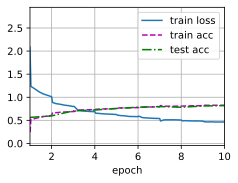

In [19]:
lr=0.8
num_epochs=10
device = torch.device("mps") # GPU
train_ch6(net,train_iter,test_iter,num_epochs,lr,device)

- 卷积神经网络（CNN）是一类使用卷积层的网络。

- 在卷积神经网络中，我们组合使用卷积层、非线性激活函数和汇聚层。

- 为了构造高性能的卷积神经网络，我们通常对卷积层进行排列，逐渐降低其表示的空间分辨率，同时增加通道数。

- 在传统的卷积神经网络中，卷积块编码得到的表征在输出之前需由一个或多个全连接层进行处理。

- LeNet是最早发布的卷积神经网络之一